In [1]:
# Make sure to have the packages numpy, scikit-learn, and Tensorflow

# import numpy first
import numpy as np

In [2]:
# Given y vector of labels, return matrix Y whose i-th row is the one-hot vector of label y_i 
# If eps is not 0, then need to compute the smoothed one-hot vectors instead
# If k is 0, then need to infer its value instead
def one_hot(y, k=0, eps=0):
    Y = np.ones((y.shape[0],k))*eps/k
    for i in range(y.shape[0]):
        Y[i,y[i]] += 1-eps
    return Y

In [3]:
class GenericLoss:
    def __init__(self, name="", dims = [], W0 = []):
        self.name = name
        assert dims != [] or W0 != [], 'Must set dims or W0'
        if W0 == []:
            self.W = np.zeros(dims)
        else:
            self.W = W0
        self.k, self.d = self.W.shape
    
    def Set(self, W):
        self.W = W
    
    def Get(self):
        return self.W
    
    def Update(self, dW):
        self.W += dW
    
    def RowNorms(self):
        return np.linalg.norm(self.W, axis = 1)
    
    def Project(self, rad):
        proj = self.RowNorms()/rad
        proj[proj > 1] = 1
        return np.reshape(proj, (proj.shape[0],1))*self.W
    
    def Predict(self, X):
        return X @ self.W.T
    
    def PredictLabels(self, X):
        return np.argmax(self.Predict(X), axis = 1)
    
    def Error(self, X, y):
        return np.sum(self.PredictLabels(X) != y)
        
    def Loss(self, X, y):
        pass
    
    def Gradient(self, X, y):
        pass

In [4]:
class CrossEntropy(GenericLoss):
    def __init__(self, name="", dims = [], W0 = [], eps=1e-6):
        super().__init__(name, dims, W0)
        self.eps = eps
    
    def Gety (self, X, y):
        z = self.Predict(X);
        zMax = np.amax(z, axis = 1)
        z -= np.reshape(zMax, (zMax.shape[0], 1))
        tot = np.sum(np.exp(z), axis = 1)
        yhat = np.exp(z)
        yhat /= np.reshape(tot, (tot.shape[0], 1))
        Y = one_hot(y, self.k, self.eps)
        return yhat, Y
        
    def Loss(self, X, y):
        yhat, Y = self.Gety (X, y)
        #print(y.shape)
        #y = np.reshape(y, (y.shape[0],1))
        loss = np.sum(Y * np.log(Y / yhat)) / Y.shape[0]
        return loss
    
    def Gradient(self, X, y):
        yhat, Y = self.Gety (X, y)
        grad = (yhat - Y).T @ X / Y.shape[0]
        return grad

class LogisticOvA(GenericLoss):
    def Gety(self, y):
        Y = one_hot(y, self.k, 0)
        Y = 2*Y-1
        return Y
    
    # compute the OvA loss as defined above.
    def Loss(self, X, y):
        ybar = self.Gety(y)
        z = self.Predict(X)
        sigmoid =  np.log(1+np.exp(-ybar*z))
        loss = np.sum(sigmoid) / y.shape[0]
        return loss
        
    def Gradient(self, X, y):
        ybar = self.Gety(y)
        z = self.Predict(X)
        der = ybar / (1+np.exp(ybar*z))
        grad = - der.T @ X / y.shape[0]
        return grad

In [5]:
def TestLoss(loss_tested):
    n, d, k, tests = 100, 10, 7, 1000
    test_loss = loss_tested(W0=[], dims=(k, d))
    
    for _ in range(tests):
        X, W = np.random.randn(n, d), np.random.randn(k, d)
        test_loss.Set(W)
    
        y, y_rand = test_loss.PredictLabels(X), np.random.randint(0, k, n)
        loss1 = test_loss.Loss(X, y)
        loss2 = test_loss.Loss(X, y_rand)
        assert loss1 < loss2, "Loss test failed (%f >= %f)" % (loss1, loss2)
    
        grad1 = test_loss.Gradient(X, y)
        norm_grad1 = np.linalg.norm(grad1)
        norm_grad2 = np.linalg.norm(test_loss.Gradient(X,y_rand))
        assert norm_grad1 < norm_grad2, "Gradient norm test failed (%f >= %f)" % (norm_grad1, norm_grad2)
        
        test_loss.Update(-0.01 * grad1)
        norm_grad3 = np.linalg.norm(test_loss.Gradient(X,y))
        assert norm_grad3 < norm_grad1, "Gradient step test failed (%f >= %f)" % (norm_grad3, norm_grad1)
    
    return True

LossTested = CrossEntropy
if TestLoss(LossTested): print('CE Test Passed')
LossTested = LogisticOvA
if TestLoss(LossTested): print('Logistic OvA Test Passed')

CE Test Passed
Logistic OvA Test Passed


Below are methods from previous assignments for data processing and training. No need to reimplement these.

In [6]:
# Sample a mini-batch w/ or w/o replacement
from numpy.random import randint
from numpy.random import permutation
class IndexSampler:
    def __init__(self, d):
        self.d = d
        self.prm = None
    
    def sample_new_index(self, replace=0):
        if replace:
            return randint(self.d)
        if self.prm is None:
            self.prm = permutation(self.d)
            self.head = 0
        ind = self.prm[self.head]
        self.head += 1
        if self.head == self.d:
            self.head = 0
            self.prm = None
        return ind

In [7]:
def learning_rate_schedule(eta0, epochs, mode):
    base_t = 10.0
    if mode == 'fixed_t':
        return eta0 * np.ones(epochs)
    if mode == 'sqrt_t':
        return eta0 * np.ones(epochs) / (base_t + np.sqrt(np.arange(epochs)))
    if mode == 'linear_t':
        return eta0 * np.ones(epochs) / (base_t + np.arange(epochs))
    print('invalid mode for learning rate schedule: %s' % mode)
    return []

In [8]:
def SGD(X, y, Loss, params):
    h = params
    pstr, rad, replace = h['pstr'], h['rad'], h['replace']
    eta0, epochs, bs, lrmode = h['eta0'], h['epochs'], h['batch_size'], h['lr_mode']
    n, d = X.shape
    nbs = int(n / bs)
    k = max(y) + 1
    ls = Loss(W0=[], dims=(k, d))
    eta_t = learning_rate_schedule(eta0, epochs, lrmode)
    losses = [ls.Loss(X, y)]
    errors = [ls.Error(X, y)]
    sampler = IndexSampler(nbs)
    for e in range(1, epochs * nbs):
        head = sampler.sample_new_index(replace) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        gw = ls.Gradient(Xt, yt)
        ls.Update(-eta_t[e // nbs] * gw)
        if rad > 0: ls.Project(rad)
        if e % nbs == 0:
            losses.append(ls.Loss(X, y))
            errors.append(ls.Error(X, y))
        if (e % (nbs * 10)) == 0:
            print(pstr.format(e // nbs, losses[-1], errors[-1]))
    return ls, losses, errors

In [9]:
# import matplotlib and get the mnist dataset from tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, y_train), (X_test, y_test) = keras_mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [10]:
# normalize the data by subtracting the mean and dividing by std
def normalize(X, bias=0):
    n, d = X.shape
    m = np.mean(X, axis=1).reshape(n, 1) * np.ones((1, d))
    s = np.std(X, axis=1).reshape(n, 1) * np.ones((1, d))
    Xn = (X - m) / s
    if bias != 0:
        Xn = np.hstack((Xn, bias * np.ones((n, 1))))
    return Xn

# flatten the images into d-dimensional vectors for training
def flatten_images(X):
    s = X.shape
    n = s[0]
    d = np.prod(s[1:])
    return X.reshape(n, d)

Xtr = normalize(flatten_images(X_train), bias = 1)
Xte = normalize(flatten_images(X_test), bias = 1)

In [11]:
h = dict()
h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5d}'
h['rad'] = 10.0
h['replace'] = 0
h['eta0'] = 1.0
h['epochs'] = 500
h['batch_size'] = 1000
h['lr_mode'] = 'sqrt_t'

lsCE, lossesCE, errorsCE = SGD(Xtr, y_train, CrossEntropy, h)

Epoch: 10  Loss: 0.285  Error:  4778
Epoch: 20  Loss: 0.271  Error:  4557
Epoch: 30  Loss: 0.263  Error:  4367
Epoch: 40  Loss: 0.258  Error:  4274
Epoch: 50  Loss: 0.256  Error:  4257
Epoch: 60  Loss: 0.253  Error:  4193
Epoch: 70  Loss: 0.251  Error:  4130
Epoch: 80  Loss: 0.249  Error:  4088
Epoch: 90  Loss: 0.247  Error:  4058
Epoch: 100  Loss: 0.246  Error:  4044
Epoch: 110  Loss: 0.245  Error:  4019
Epoch: 120  Loss: 0.244  Error:  3990
Epoch: 130  Loss: 0.243  Error:  3961
Epoch: 140  Loss: 0.242  Error:  3981
Epoch: 150  Loss: 0.241  Error:  3929
Epoch: 160  Loss: 0.240  Error:  3948
Epoch: 170  Loss: 0.239  Error:  3909
Epoch: 180  Loss: 0.239  Error:  3939
Epoch: 190  Loss: 0.238  Error:  3905
Epoch: 200  Loss: 0.237  Error:  3875
Epoch: 210  Loss: 0.237  Error:  3895
Epoch: 220  Loss: 0.238  Error:  3952
Epoch: 230  Loss: 0.236  Error:  3870
Epoch: 240  Loss: 0.236  Error:  3899
Epoch: 250  Loss: 0.235  Error:  3916
Epoch: 260  Loss: 0.235  Error:  3859
Epoch: 270  Loss: 0.2

In [12]:
print("Loss: %.3f Error: %d" % (lsCE.Loss(Xte,y_test), lsCE.Error(Xte,y_test)))
print("Error Rate: %.3f" % (lsCE.Error(Xte, y_test)/y_test.shape[0]))

Loss: 0.264 Error: 726
Error Rate: 0.073


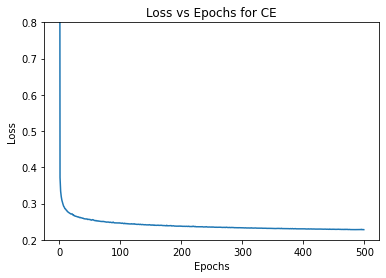

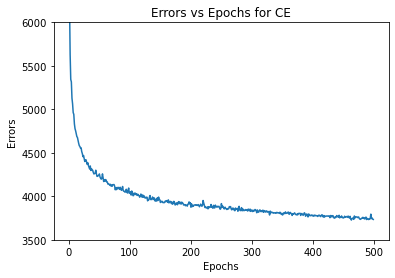

In [13]:
plt.figure(1)
plt.plot(lossesCE)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for CE')
plt.ylim(0.2, 0.8);

plt.figure(2)
plt.plot(errorsCE)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs for CE')
plt.ylim(3500, 6000);

In [14]:
C = np.zeros((10,10))
predictions = lsCE.PredictLabels(Xte)
for i in range(predictions.shape[0]):
    C[y_test[i], predictions[i]] += 1
k = max(y_test) + 1
assert np.array_equal(np.argmax(C, axis=1), np.arange(k))

In [15]:
lsOvA, lossesOvA, errorsOvA = SGD(Xtr, y_train, LogisticOvA, h)

Epoch: 10  Loss: 0.739  Error:  5479
Epoch: 20  Loss: 0.710  Error:  5217
Epoch: 30  Loss: 0.694  Error:  5105
Epoch: 40  Loss: 0.683  Error:  4980
Epoch: 50  Loss: 0.675  Error:  4891
Epoch: 60  Loss: 0.668  Error:  4818
Epoch: 70  Loss: 0.663  Error:  4790
Epoch: 80  Loss: 0.659  Error:  4752
Epoch: 90  Loss: 0.654  Error:  4721
Epoch: 100  Loss: 0.650  Error:  4705
Epoch: 110  Loss: 0.648  Error:  4707
Epoch: 120  Loss: 0.644  Error:  4690
Epoch: 130  Loss: 0.642  Error:  4656
Epoch: 140  Loss: 0.640  Error:  4644
Epoch: 150  Loss: 0.638  Error:  4598
Epoch: 160  Loss: 0.635  Error:  4608
Epoch: 170  Loss: 0.634  Error:  4590
Epoch: 180  Loss: 0.632  Error:  4588
Epoch: 190  Loss: 0.629  Error:  4541
Epoch: 200  Loss: 0.628  Error:  4541
Epoch: 210  Loss: 0.627  Error:  4533
Epoch: 220  Loss: 0.625  Error:  4551
Epoch: 230  Loss: 0.623  Error:  4528
Epoch: 240  Loss: 0.623  Error:  4510
Epoch: 250  Loss: 0.621  Error:  4481
Epoch: 260  Loss: 0.620  Error:  4465
Epoch: 270  Loss: 0.6

In [16]:
print("Loss: %.3f Error: %d" % (lsOvA.Loss(Xte,y_test), lsOvA.Error(Xte,y_test)))
print("Error Rate: %.3f" % (lsOvA.Error(Xte, y_test)/y_test.shape[0]))

Loss: 0.630 Error: 795
Error Rate: 0.080


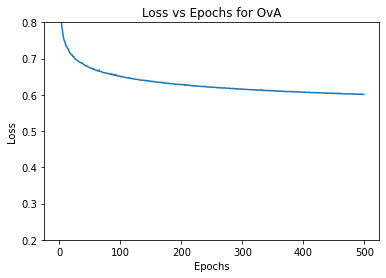

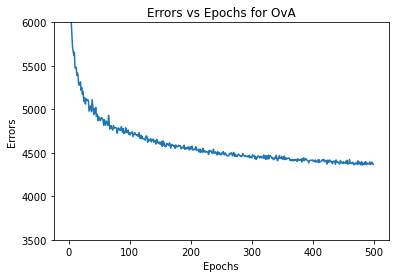

In [17]:
plt.figure(1)
plt.plot(lossesOvA)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for OvA')
plt.ylim(0.2, 0.8);

plt.figure(2)
plt.plot(errorsOvA)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs for OvA')
plt.ylim(3500, 6000);

In [18]:
C2 = np.zeros((10,10))
predictions = lsOvA.PredictLabels(Xte)
for i in range(predictions.shape[0]):
    C2[y_test[i], predictions[i]] += 1
k = max(y_test) + 1
assert np.array_equal(np.argmax(C2, axis=1), np.arange(k))

CrossEntropy yields better results than Logistic One vs All because it incorporates data from all classes to make a prediction, instead of running each seperately.

In [29]:
from sklearn.datasets import fetch_20newsgroups
from collections import Counter

def get_20newsgroups_data():
    newsgroups_train = fetch_20newsgroups(subset='train')
    newsgroups_test  = fetch_20newsgroups(subset='test')
    return newsgroups_train, newsgroups_test

def construct_vocabulary(data, vs):
    vocab = Counter()
    for text in data:
        for word in text.split(' '):
            vocab[word.lower()] += 1
    word2index = dict(vocab.most_common(vs))
    i = 0
    for k in word2index.keys():
        word2index[k] = i
        i += 1
    return word2index

def text_to_vec(data, vocab):
    def norm_rows(M):
        return np.sqrt(np.sum(M * M, axis=1, keepdims=True))
    def project_rows(M, r):
        return M * np.minimum(r / norm_rows(M), 1.0)
    n = len(data)
    d = len(vocab)
    X = np.zeros((n, d))
    i = 0
    for text in data:
        for word in text.split(' '):
            if word.lower() in vocab:
                X[i, vocab[word.lower()]] += 1.0
        i += 1
    # Convert to log-frequencies and normalize to have ||X[i,*]||=1
    X = project_rows(np.log(X + 1.0), 1.0)
    return X

In [30]:
vsize = 1000
train, test = get_20newsgroups_data()
vocab = construct_vocabulary(train.data, vsize)
Xtr = text_to_vec(train.data, vocab)
Xte = text_to_vec(test.data, vocab)
y_train = train.target
y_test = test.target

In [31]:
hNews = dict()
hNews['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5d}'
hNews['rad'] = 40.0
hNews['replace'] = 0
hNews['eta0'] = 1000.0
hNews['epochs'] = 500
hNews['batch_size'] = 1000
hNews['lr_mode'] = 'sqrt_t'

lsNewsCE, lossesNewsCE, errorsNewsCE = SGD(Xtr, y_train, CrossEntropy, hNews)

Epoch: 10  Loss: 1.307  Error:  3622
Epoch: 20  Loss: 1.054  Error:  2918
Epoch: 30  Loss: 0.929  Error:  2599
Epoch: 40  Loss: 0.849  Error:  2360
Epoch: 50  Loss: 0.792  Error:  2208
Epoch: 60  Loss: 0.748  Error:  2084
Epoch: 70  Loss: 0.712  Error:  1978
Epoch: 80  Loss: 0.682  Error:  1868
Epoch: 90  Loss: 0.656  Error:  1779
Epoch: 100  Loss: 0.634  Error:  1723
Epoch: 110  Loss: 0.615  Error:  1656
Epoch: 120  Loss: 0.598  Error:  1612
Epoch: 130  Loss: 0.583  Error:  1569
Epoch: 140  Loss: 0.569  Error:  1525
Epoch: 150  Loss: 0.556  Error:  1469
Epoch: 160  Loss: 0.544  Error:  1452
Epoch: 170  Loss: 0.534  Error:  1408
Epoch: 180  Loss: 0.524  Error:  1375
Epoch: 190  Loss: 0.514  Error:  1345
Epoch: 200  Loss: 0.506  Error:  1308
Epoch: 210  Loss: 0.498  Error:  1286
Epoch: 220  Loss: 0.490  Error:  1276
Epoch: 230  Loss: 0.483  Error:  1244
Epoch: 240  Loss: 0.476  Error:  1228
Epoch: 250  Loss: 0.469  Error:  1172
Epoch: 260  Loss: 0.463  Error:  1178
Epoch: 270  Loss: 0.4

In [32]:
print("Loss: %.3f Error: %d" % (lsNewsCE.Loss(Xte,y_test), lsNewsCE.Error(Xte,y_test)))
print("Error Rate: %.3f" % (lsNewsCE.Error(Xte, y_test)/y_test.shape[0]))

Loss: 1.615 Error: 3344
Error Rate: 0.444


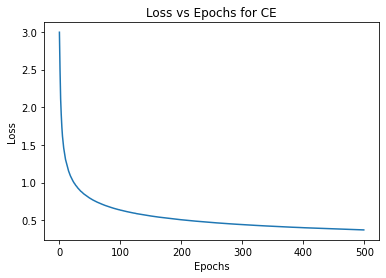

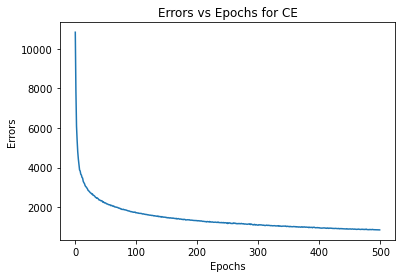

In [33]:
plt.figure(1)
plt.plot(lossesNewsCE)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for CE')
#plt.ylim(0.2, 0.8);

plt.figure(2)
plt.plot(errorsNewsCE)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs for CE')
#plt.ylim(3500, 6000);

k = max(y_test) + 1
k2 = max(y_train) + 1
k = max(k,k2)
C = np.zeros((k,k))
predictions = lsNewsCE.PredictLabels(Xte)
for i in range(predictions.shape[0]):
    C[y_test[i], predictions[i]] += 1
assert np.array_equal(np.argmax(C, axis=1), np.arange(k))

In [34]:
lsNewsOvA, lossesNewsOvA, errorsNewsOvA = SGD(Xtr, y_train, LogisticOvA, hNews)

Epoch: 10  Loss: 2.254  Error:  3705
Epoch: 20  Loss: 1.930  Error:  3041
Epoch: 30  Loss: 1.764  Error:  2719
Epoch: 40  Loss: 1.653  Error:  2512
Epoch: 50  Loss: 1.575  Error:  2350
Epoch: 60  Loss: 1.513  Error:  2214
Epoch: 70  Loss: 1.464  Error:  2133
Epoch: 80  Loss: 1.421  Error:  2065
Epoch: 90  Loss: 1.385  Error:  1988
Epoch: 100  Loss: 1.354  Error:  1947
Epoch: 110  Loss: 1.327  Error:  1914
Epoch: 120  Loss: 1.302  Error:  1858
Epoch: 130  Loss: 1.280  Error:  1823
Epoch: 140  Loss: 1.260  Error:  1769
Epoch: 150  Loss: 1.242  Error:  1735
Epoch: 160  Loss: 1.225  Error:  1697
Epoch: 170  Loss: 1.209  Error:  1683
Epoch: 180  Loss: 1.195  Error:  1638
Epoch: 190  Loss: 1.182  Error:  1608
Epoch: 200  Loss: 1.169  Error:  1581
Epoch: 210  Loss: 1.157  Error:  1563
Epoch: 220  Loss: 1.147  Error:  1562
Epoch: 230  Loss: 1.135  Error:  1520
Epoch: 240  Loss: 1.126  Error:  1521
Epoch: 250  Loss: 1.116  Error:  1490
Epoch: 260  Loss: 1.107  Error:  1483
Epoch: 270  Loss: 1.0

In [35]:
print("Loss: %.3f Error: %d" % (lsNewsOvA.Loss(Xte,y_test), lsNewsOvA.Error(Xte,y_test)))
print("Error Rate: %.3f" % (lsNewsOvA.Error(Xte, y_test)/y_test.shape[0]))

Loss: 2.514 Error: 3278
Error Rate: 0.435


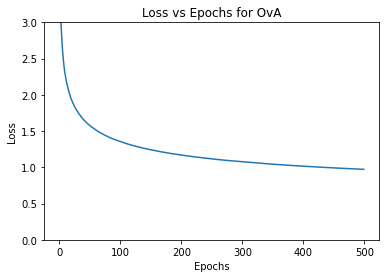

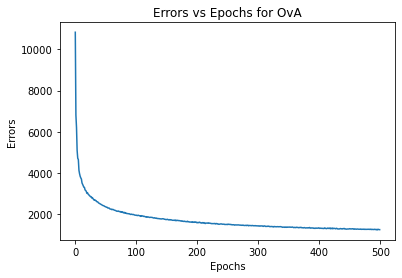

In [36]:
plt.figure(1)
plt.plot(lossesNewsOvA)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for OvA')
plt.ylim(0, 3);

plt.figure(2)
plt.plot(errorsNewsOvA)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs for OvA')
#plt.ylim(3500, 6000);

k = max(y_test) + 1
k2 = max(y_train) + 1
k = max(k,k2)
C = np.zeros((k,k))
predictions = lsNewsOvA.PredictLabels(Xte)
for i in range(predictions.shape[0]):
    C[y_test[i], predictions[i]] += 1
assert np.array_equal(np.argmax(C, axis=1), np.arange(k))